In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
import scipy.stats as sc
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap
import time

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

In [5]:
amip_ds = xr.open_dataset('amip_aht.nc')
hist_ds = xr.open_dataset('hist_aht.nc')
reanalysis_ds = xr.open_dataset('reanalysis_aht.nc')

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [6]:
#All CESM runs are offset by one month - need to fix this, also have the spike every 10 year issue with this data

cesm2_time = pd.date_range("1950-01-01","2014-12-31",freq='1M')
cesm2_le_ds_full = xr.open_dataset('../CESM_aht/CESM2_LENS2_aht_ds.nc')
cesm2_le_ds_full['time'] = cesm2_time
cesm2_le_ds = cesm2_le_ds_full.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_amip_time = pd.date_range("1949-12-31","2014-11-30",freq='1M')

cesm2_amip_le_ds = xr.open_dataset('../CESM_aht/CESM2_GOGA_AMIP_aht_ds.nc')
cesm2_amip_le_ds['time'] = cesm2_amip_time
cesm2_amip_le_ds = cesm2_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_toga_amip_le_ds = xr.open_dataset('../CESM_aht/CESM2_TOGA_AMIP_aht_ds.nc')
cesm2_toga_amip_le_ds['time'] = cesm2_amip_time
cesm2_toga_amip_le_ds = cesm2_toga_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_le_trends = cesm2_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_amip_le_trends = cesm2_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_toga_amip_le_trends = cesm2_toga_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [61]:
def detrend_dim(da, dim='year', deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [173]:
def calc_std_error(time_series):
    
    years = np.unique(time_series.time.dt.year)
    N = len(years)
    
    year_series = time_series.groupby('time.year').mean('time')
    
    trend_data = year_series.polyfit(dim = 'year', deg = 1).polyfit_coefficients
    
    #Now detrend it for calculating autocorrelation
    fit = xr.polyval(year_series['year'], trend_data)
    year_series_detrend = year_series - fit

    autocorr = abs(np.corrcoef(year_series_detrend[1:], year_series_detrend[:-1])[0,1])

    Neff = N * ((1-autocorr)/(1+autocorr))

    #residuals = np.sum(((years * trend_data.sel(degree=1).values + trend_data.sel(degree=0).values) - year_series.values) ** 2)
    residuals = (year_series_detrend ** 2).sum()
    
    x_variance = np.sum((years - np.mean(years))**2)

    se_sqd = residuals / (Neff - 2)
    
    sa_sqd = se_sqd / x_variance

    sa = np.sqrt(sa_sqd)
    
    return sa

In [71]:
def calc_Neff(time_series):
    
    years = np.unique(time_series.time.dt.year)
    N = len(years)
    
    year_series = time_series.groupby('time.year').mean('time')
    
    #Now detrend it to calculate autocorrelation
    year_series = detrend_dim(year_series)

    autocorr = abs(np.corrcoef(year_series[1:], year_series[:-1])[0,1])

    Neff = N * ((1-autocorr)/(1+autocorr))
    
    return Neff

In [72]:
vars_list = [
 'total_aht',
 'mmc_aht',
 'se_aht',
 'te_aht',
 'eddy_aht']

vars_list_reanalysis = [
 'total_aht',
 'mmc_aht',
 'se_aht',
 'te_aht',
 'eddy_aht']

#vars_list = ['total_mht',
 #'total_aht',
 #'total_oht',
 #'total_aht_dry_pot',
 #'total_aht_moist',
 #'mmc_aht',
 #'mmc_aht_dry',
 #'mmc_aht_moist',
 #'mmc_aht_pot',
# 'mmc_aht_dry_pot',
 #'se_aht',
 #'se_aht_dry',
 #'se_aht_moist',
 #'se_aht_pot',
# 'se_aht_dry_pot',
# 'te_aht',
# 'te_aht_moist',
 #'te_aht_dry_pot',
 #'eddy_aht',
 #'eddy_aht_moist',
 #'eddy_aht_dry_pot']

#vars_list_reanalysis = [
# 'total_aht',
 #'total_aht_dry_pot',
 #'total_aht_moist',
 #'mmc_aht',
 #'mmc_aht_dry',
 #'mmc_aht_moist',
 #'mmc_aht_dry_pot',
 #'se_aht',
 #'se_aht_dry',
 #'se_aht_moist',
 #'se_aht_dry_pot',
 #'te_aht',
 #'te_aht_moist',
 #'te_aht_dry_pot',
 #'eddy_aht',
 #'eddy_aht_moist',
 #'eddy_aht_dry_pot']

In [178]:
def calc_std_error_ds(ds, ds_name, vars_list):
    
    var_dict = {}

    for var_name in vars_list:
        var_dict[var_name] = (['model', 'latitude'], np.zeros((len(ds.model), len(ds.latitude))))  
        
    for var_name in vars_list:
        print(var_name)
        for j in range(len(ds.model)):
            for k in range(len(ds.latitude)):
                var_dict[var_name][1][j,k] = calc_std_error(ds[var_name].isel(model=j, latitude=k))
                
    final_ds = xr.Dataset(var_dict,
                    coords=dict(
                        model=ds.model,
                        latitude=ds.latitude))

    final_ds.to_netcdf(f'{ds_name}_trend_std_error.nc')



In [74]:
def calc_Neff_ds(ds, ds_name, vars_list):
    
    var_dict = {}

    for var_name in vars_list:
        var_dict[var_name] = (['model', 'latitude'], np.zeros((len(ds.model), len(ds.latitude))))  
        
    for var_name in vars_list:
        print(var_name)
        for j in range(len(ds.model)):
            for k in range(len(ds.latitude)):
                var_dict[var_name][1][j,k] = calc_Neff(ds[var_name].isel(model=j, latitude=k))
                
    final_ds = xr.Dataset(var_dict,
                    coords=dict(
                        model=ds.model,
                        latitude=ds.latitude))

    final_ds.to_netcdf(f'{ds_name}_trend_Neff.nc')



In [195]:
#calc_std_error_ds(amip_ds, 'amip_ds', vars_list)

In [180]:
#calc_Neff_ds(amip_ds, 'amip_ds', vars_list)

In [196]:
#calc_std_error_ds(hist_ds, 'hist_ds', vars_list)

In [197]:
#calc_Neff_ds(hist_ds, 'hist_ds', vars_list)

In [198]:
#calc_std_error_ds(reanalysis_ds, 'reanalysis_ds', vars_list_reanalysis)

In [199]:
#calc_Neff_ds(reanalysis_ds, 'reanalysis_ds', vars_list_reanalysis)

In [200]:
#calc_std_error_ds(cesm2_le_ds, 'cesm2_le_ds', vars_list)

In [201]:
#calc_Neff_ds(cesm2_le_ds, 'cesm2_le_ds', vars_list)

In [191]:
#calc_std_error_ds(cesm2_amip_le_ds, 'cesm2_amip_le_ds', vars_list)

In [192]:
#calc_Neff_ds(cesm2_amip_le_ds, 'cesm2_amip_le_ds', vars_list)

In [193]:
#calc_std_error_ds(cesm2_toga_amip_le_ds, 'cesm2_toga_amip_le_ds', vars_list)

In [194]:
#calc_Neff_ds(cesm2_toga_amip_le_ds, 'cesm2_toga_amip_le_ds', vars_list)

In [203]:
hist_pr = xr.open_dataset('hist_pr_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
amip_pr = xr.open_dataset('amip_pr_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
cesm_pr = xr.open_dataset('cesm2_lens2_pr.nc').sel(time=slice('1980-01-01','2014-12-31'))
reanalysis_pr = xr.open_dataset('reanalysis_precip.nc')

In [213]:
hist_pr = hist_pr.rename({'lat':'latitude'})
amip_pr = amip_pr.rename({'lat':'latitude'})
cesm_pr = cesm_pr.rename({'lat':'latitude'})

In [214]:
calc_std_error_ds(hist_pr, 'hist_pr', ['pr'])

pr


In [215]:
calc_Neff_ds(hist_pr, 'hist_pr', ['pr'])

pr


In [216]:
calc_std_error_ds(amip_pr, 'amip_pr', ['pr'])

pr


In [217]:
calc_Neff_ds(amip_pr, 'amip_pr', ['pr'])

pr


In [218]:
calc_std_error_ds(cesm_pr, 'cesm_pr', ['PRECT'])

PRECT


In [219]:
calc_Neff_ds(cesm_pr, 'cesm_pr', ['PRECT'])

PRECT


In [220]:
calc_std_error_ds(reanalysis_pr, 'reanalysis_pr', ['tp'])

tp


In [221]:
calc_Neff_ds(reanalysis_pr, 'reanalysis_pr', ['tp'])

tp


In [223]:
amip_sst = xr.open_dataset('amip_sst.nc').sel(time=slice('1980-01-01','2014-12-31'))
hist_sst = xr.open_dataset('hist_sst_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
obs_sst = xr.open_dataset('ersstv5.nc').sel(time=slice('1980-01-01','2014-12-31'))
cesm_sst = xr.open_dataset('cesm2_sst.nc').sel(time=slice('1980-01-01','2014-12-31'))

In [224]:
amip_sst = amip_sst.mean('lon').rename({'lat':'latitude'})
hist_sst = hist_sst.mean('lon').rename({'lat':'latitude'})
cesm_sst = cesm_sst.rename({'lat':'latitude'})

In [225]:
calc_std_error_ds(hist_sst, 'hist_sst', ['ts'])
calc_Neff_ds(hist_sst, 'hist_sst', ['ts'])

ts
ts


In [228]:
#calc_std_error_ds(amip_sst, 'amip_sst', ['tosbcs'])
#calc_Neff_ds(amip_sst, 'amip_sst', ['tosbcs'])

In [229]:
calc_std_error_ds(cesm_sst, 'cesm_sst', ['SST'])
calc_Neff_ds(cesm_sst, 'cesm_sst', ['SST'])

SST
SST


In [21]:
var_dict = {}

for var_name in vars_list:
    var_dict[var_name] = (['model', 'latitude'], np.zeros((len(amip_ds.model), len(amip_ds.latitude))))   

In [25]:

for var_name in vars_list:
    print(var_name)
    for j in range(len(amip_ds.model)):
        for k in range(len(amip_ds.latitude)):
            var_dict[var_name][1][j,k] = calc_std_error(amip_ds[var_name].isel(model=j, latitude=k))

total_mht


/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarni

KeyboardInterrupt: 

In [ ]:
final_ds = xr.Dataset(var_dict,
                    coords=dict(
                        model=amip_ds.model,
                        latitude=amip_ds.latitude))

final_ds.to_netcdf('amip_ds_trend_std_error.nc')

### OLD

In [248]:
def calc_std_error(time_series):
    
    years = np.unique(time_series.time.dt.year)
    N = len(years)
    
    year_series = time_series.groupby('time.year').mean('time')

    autocorr = np.corrcoef(year_series[1:], year_series[:-1])[0,1]

    Neff = N * ((1-autocorr)/(1+autocorr))

    trend_data = year_series.polyfit(dim = 'year', deg = 1).polyfit_coefficients
    
    residuals = np.sum(((years * trend_data.sel(degree=1).values + trend_data.sel(degree=0).values) - year_series.values) ** 2)

    x_variance = np.sum((years - np.mean(years))**2)

    se_sqd = residuals / (Neff - 2)
    sa_sqd = se_sqd / x_variance

    sa = np.sqrt(sa_sqd)
    
    return sa

In [262]:
vars_list = list(amip_ds.keys())

['total_mht',
 'total_aht',
 'total_oht',
 'total_aht_dry_pot',
 'total_aht_moist',
 'mmc_aht',
 'mmc_aht_dry',
 'mmc_aht_moist',
 'mmc_aht_pot',
 'mmc_aht_dry_pot',
 'se_aht',
 'se_aht_dry',
 'se_aht_moist',
 'se_aht_pot',
 'se_aht_dry_pot',
 'te_aht',
 'te_aht_moist',
 'te_aht_dry_pot',
 'eddy_aht',
 'eddy_aht_moist',
 'eddy_aht_dry_pot',
 'mass',
 'strm_fnct']

In [265]:
vars_list = list(amip_ds.keys())
amip_sa = np.zeros((len(vars_list), len(amip_ds.model), len(amip_ds.latitude)))


for i in range(len(vars_list)):
    print(vars_list[i])
    for j in range(len(amip_ds.model)):
        for k in range(len(amip_ds.latitude)):
            amip_sa[i,j,k] = calc_std_error(amip_ds[vars_list[i]].isel(model=j, latitude=k))
            

total_mht


/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarni

total_aht


/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


KeyboardInterrupt: 

In [252]:
start_time = time.time()

calc_std_error(amip_ds.te_aht.sel(latitude=40, method='nearest').isel(model=0))

print(time.time() - start_time)

0.06247425079345703


In [255]:
.06 * 181 * 30 * 4 / 60

21.719999999999995

In [222]:
test_lat = -50
test_model = 1

years = np.unique(amip_ds.time.dt.year)
N = len(years)

test_val = amip_ds.te_aht.sel(latitude=test_lat, method='nearest').isel(model=test_model).groupby('time.year').mean('time')

autocorr = np.corrcoef(test_val.values[1:], test_val.values[:-1])[0,1]

Neff = N * ((1-autocorr)/(1+autocorr))

test_residuals = amip_trends.te_aht_polyfit_residuals.sel(latitude=test_lat, method='nearest').isel(model=test_model)

test_trend = amip_trends.te_aht_polyfit_coefficients.sel(latitude=test_lat, method='nearest').isel(model=test_model).sel(degree=1)

#test_var = np.sum((test_val - test_val.mean('year'))**2)
test_var = np.sum((years - np.mean(years))**2)

cov_test = np.sqrt(np.diag(amip_trends.te_aht_polyfit_covariance.sel(latitude=test_lat, method='nearest').isel(model=test_model)))

test_se_sqd = test_residuals / (Neff - 2)
test_sa_sqd = test_se_sqd / test_var

test_sa = np.sqrt(test_sa_sqd)

print(test_trend.values * 40 / 1e15)
print(test_sa.values * 40 / 1e15)

print(test_trend.values / test_sa.values)

print(sc.t.ppf(1-0.025, Neff))

-0.2789539273956459
0.083625935382313
-3.335734615348111
2.1554799244874285


In [223]:
autocorr

0.4493768969917069

In [142]:
test_trend * 40 / 1e15

<xarray.DataArray 'te_aht_polyfit_coefficients' ()>
array(0.16225391)
Coordinates:
    degree    int64 1
    model     <U7 'TaiESM1'
    latitude  int64 50

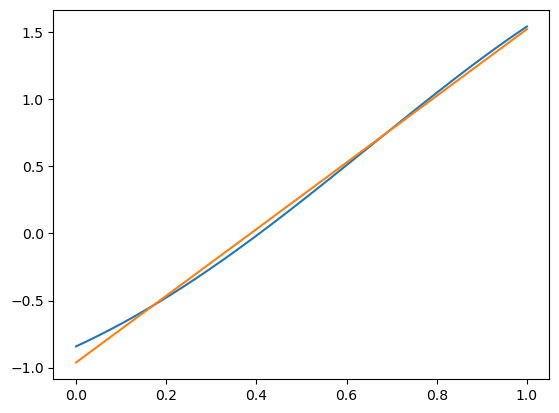

[0.0042437  0.00245071]


In [104]:
x = np.linspace(0,1,1000)
# comment and uncomment the last term to see how the fit appears in the figure,
# and how the covariances of the single polynomial coefficients vary in turn.
y = np.cos(x) * x**2 + x + np.sin(x - 1.) \
#     + (x * 1.3)**6

p, cov = np.polyfit(x, y, 1, cov=True)

plt.plot(x, y)
plt.plot(x, np.polyval(p,x))
plt.show()

print(np.sqrt(np.diag(cov)))

In [105]:
cov

array([[ 1.80089479e-05, -9.00447395e-06],
       [-9.00447395e-06,  6.00598713e-06]])